# Original testing

In [1]:
from utils import models
from utils.models import FioBase
import subprocess

In [2]:
f = FioBase()
fio_params = [("--bs", "16k"), 
              ("--name", "job1"), 
              ("--ioengine","libaio"), 
              ("--iodepth", "1"), 
              ("--size","20m"), 
              ("--filename","/tmp/test.fio"), 
              ("--direct", "1"),
              ("--rw", "randrw"),
              ("--runtime", "8"),
              "--group_reporting",
              "--time_based"]
param_list: list = ["--output-format=json"]
for param in fio_params:
    print(type(param))
    if type(param) == str:
        param_list.append(param)
    else:
        param_list.append(param[0] + "=" + param[1])
param_list

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'str'>
<class 'str'>


['--output-format=json',
 '--bs=8k',
 '--name=job1',
 '--ioengine=libaio',
 '--iodepth=1',
 '--size=20m',
 '--filename=/tmp/test.fio',
 '--direct=1',
 '--rw=randread',
 '--runtime=5',
 '--group_reporting',
 '--time_based']

In [ ]:
fio_process = subprocess.run(["fio"] + param_list,
                                capture_output=True)
fio_process.stdout

In [ ]:
import json
from utils.fio_runner import FioRunner
json_result = json.loads(fio_process.stdout)
fio = FioRunner()
# dir(fio)
fiobase = fio.stdout_to_FioBase(fio_process.stdout)
str(fiobase)

# FioOptimizer Class
## from optimal-io-depth-search.py

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Notes

# fio.find_optimal_iodepth()
# a = fio.best_run.prepare_args(params=fio.config)
# fio_process = subprocess.run(['fio'] + [f"{k}={v}" if v else f"{k}" for k, v in fio.config.items()], capture_output=True)
# print(fio_process)

# param_list = [f"{k}={v}" if v else f"{k}" for k, v in fio.config.items()]
# print(param_list)
# fio_process = subprocess.run(['fio'] + param_list, capture_output=True)
# fio_process.stdout
# fio_run: FioBase = FioBase()
# fio_run.parse_stdout(raw_stdout=fio_process.stdout)
# print(fio.prepare_and_run_fio(io_depth=6))
# print(fio.prepare_and_run_fio(io_depth=8))
# print(fio.prepare_and_run_fio(io_depth=10))



#  Start at 1,40
# where do I go in the middle?
# slices = 5 
# range(1,40 abs(40-1)/slices)  39/5 = 7.x 1+7, 1+(7*2), 1+(7*3), 1+(7*4)

# Future TODO - version 1.5+
# determine protocol, 
# bundle fio with the repo
# system tunables (max tcp slot table entry, others)

# TODO (for MVP)
#   128*nconnect number
#   128*nr_smb_sessions
#   either total_iops as a ratio of latency OR look at delta of total_iops as compared to the delta of latency
#       if the latency_delta is larger than iops_delta then store smallest value of latency_delta  
#   option for max_io_rate
#   option for max_io_rate_before_knee_of_curve










# for multihost, we'll have to use an fio config file (fio expects this) and not with cmdline flags

In [2]:
from utils import models
from utils.models import FioOptimizer, FioBase

# fio_params = {"--bs": "16k", 
#               "--name": "job1", 
#               "--ioengine":"libaio", 
#               "--iodepth": "1", 
#               "--size": "300m", 
#               "--filename": "/mnt/testvol/test.fio", 
#               "--direct": "1",
#               "--rw": "randrw",
#               "--runtime": "2s",
#               "--time_based": None,
#               "--group_reporting": None,
#               "--output-format": "json",
#               "--norandommap": None,
#               "--dedupe_percentage": 0,
#               "--buffer_compress_percentage": 50,
#               "--buffer_compress_chunk": 4096,
#               "--buffer_pattern": "\"aaaa\""}
# param_list: list = [f"{k}={v}" for k, v in fio_params.items()]
# print(fio_params)
# print(param_list)

fio = FioOptimizer(min=1, max=40, slices=5, fio_params=fio_params)

# # print(f"Fio Config: {fio.config}")

# is_optimial: bool = False

# starting_io_depths: list = [fio.min, fio.max]    # gotta start some where

# for io_depth in starting_io_depths:
#     fio.config['--iodepth'] = io_depth
#     # print(fio.config)
#     fio.prepare_and_run_fio(io_depths=[io_depth])
#     # fio.runs[io_depth] = fio_run


NameError: name 'fio_params' is not defined

In [5]:
fio.find_optimal_iodepth()
print(fio.best_run)

ERROR:root:Error code: 1
Error Message: b'No jobs(s) defined\n\n'


RuntimeError: Error code: 1
Error Message: b'No jobs(s) defined\n\n'

In [15]:
import pandas as pd 
import json
import ipywidgets as widgets
df = pd.DataFrame([x.__dict__ for x in fio.runs.values()])
print(df.columns)
# df.plot(x='io_depth', y='iops_latency_ratio', kind='scatter')
def my_plot(x:str, y:str, kind:str):
    df.plot(y=y, x=x, kind=kind)
# allow user to select a column from df.columns to graph as x and y for input into df.plot
# widgets.interact(df.plot, x=df.columns, y=df.columns)

widgets.interact(my_plot, x=df.columns, y=df.columns, kind=['scatter', 'line'])



Index(['read_bandwidth', 'read_latency', 'read_iops', 'write_bandwidth',
       'write_latency', 'write_iops', 'total_bandwidth', 'timestamp',
       'duration', 'total_iops', 'io_depth', 'jobs', 'ERROR_CODE',
       'iops_latency_ratio', 'avg_latency'],
      dtype='object')


interactive(children=(Dropdown(description='x', options=('read_bandwidth', 'read_latency', 'read_iops', 'write…

<function __main__.my_plot(x: str, y: str, kind: str)>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
df = pd.read_csv('fio_8K.csv')
# write a function that accepts a pandas dataframe and returns a plot

def my_plot(x:str, y:str, kind:str):
    df.plot(y=y, x=x, kind=kind)

widgets.interact(my_plot, x=df.columns, y=df.columns, kind=['scatter', 'line'])


interactive(children=(Dropdown(description='x', options=('io_depth', 'read_throughput', 'read_latency', 'read_…

<function __main__.my_plot(x: str, y: str, kind: str)>

##Notes

    # test limits (min, max)
    # test midpoint between limits
    # average results of min+midpoint and max+midpoint
    # 
    # divide total from min and max into n buckets, then go test all of them,
    # sort them 
    # range(min, max, (abs(max-min))/5)
    # slices = 5 
    # 10, 20, 2 # ((20-10)/slices = 2)
    # k = [10, 12, 14, 16, 18]
    # when I do the loop, test if k[n] is already tested
    # find the best results from min, max, k[]
    

    # while not is_optimial:
    #     sorted_runs_by_iops: list[FioBase] = sorted(self.runs, key=self.runs.get('total_iops'), reverse=True)
    #     # are we going up or down?
    #     if sorted_runs_by_iops[0].io_depth - sorted_runs_by_iops[1].io_depth <= 1:
    #         is_optimial = True
    #         self.optimal_queue_depth = sorted_runs_by_iops[0]
    #         return 
    #     else: 
    #         next_io_depth = ((sorted_runs_by_iops[0].io_depth + sorted_runs_by_iops[1].io_depth) // 2)
    #         if next_io_depth in self.runs:
    #             next_io_depth = 
    #         else:
    #             self.prepare_and_run_fio(io_depth=next_io_depth)
    

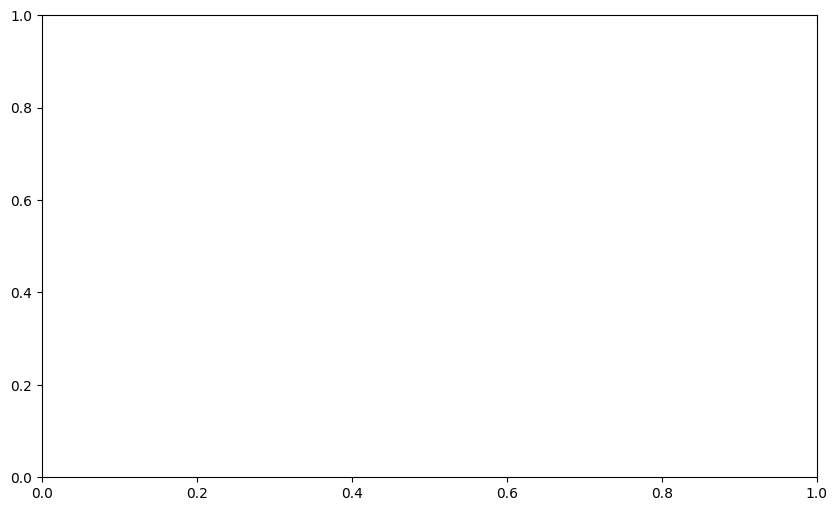

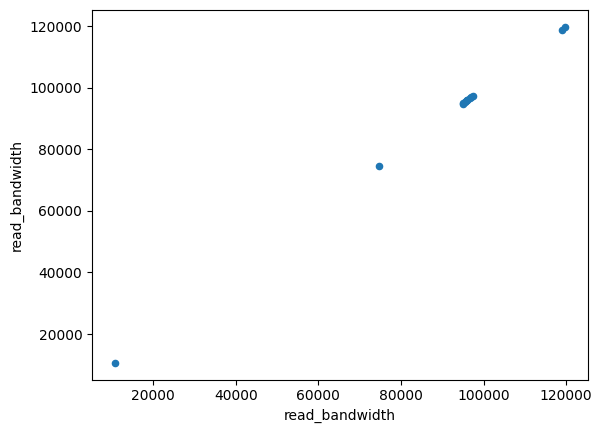

interactive(children=(Dropdown(description='x', options=('read_bandwidth', 'read_latency', 'read_iops', 'write…

<function __main__.my_plot(x: str, y: str, kind: str)>

In [16]:
import ipywidgets as widgets
import numpy as np
import matplotlib
# fio is my variable with all the good data in it

def trendline(x):
    return 0.5 * x + 100

plt, ax = matplotlib.pyplot.subplots( figsize=(10, 6) )
df = fio.to_DataFrame()



# generate a chart of iops vs latency
def my_plot(x:str, y:str, kind:str):
    trendline = np.poly1d(np.polyfit(df[x], df[y], 1))
    ax.plot(df[x], trendline(df[x]), color='red')
    df.plot(y=y, x=x, kind=kind)
    # add a trendline to the chart
    
     

widgets.interact(my_plot, x=df.columns, y=df.columns, kind=['scatter', 'line'])
